In [15]:
import re
import math
import warnings
import tqdm
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from sympy import symbols, Eq, solve
from matplotlib.pyplot import MultipleLocator
warnings.filterwarnings("ignore")


%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 

In [16]:
data1=pd.read_excel('/root/GDUT/q21/2a数据.xlsx')
data2=pd.read_excel('/root/GDUT/q21/时间点.xlsx')
data_f_1=pd.read_excel('/root/GDUT/附表1-检索表格-流水号vs时间.xlsx')
data_f_time=pd.read_excel('/root/GDUT/q21/时间点.xlsx')
data1=data1.rename(columns={'首次检查流水号':'入院首次影像检查流水号'})

In [17]:
# 转换为时间戳格式
columns_to_convert = data_f_time.columns[1:]

data_f_time[columns_to_convert] = data_f_time[columns_to_convert].apply(pd.to_datetime)
# Datetime对象转换为秒级的时间戳形式
data_f_time[columns_to_convert] = data_f_time[columns_to_convert].apply(lambda x: x.astype(int) // 10**9)
# 将负数的时间戳转变为空值
data_f_time[data_f_time.columns[1:]] = data_f_time[data_f_time.columns[1:]].apply(lambda x: x.mask(x < 0))


In [18]:
# 找到两个 DataFrame 共有的列名
common_columns = data_f_time.columns.intersection(data1.columns)

# 使用 data_f_time 中的列替换 _1a 中的相同列名的列

data1[common_columns] = data_f_time[common_columns]



In [19]:
Err=[data1['入院首次影像检查流水号'][i]-data1['发病到首次影像检查时间间隔'][i]*3600 for i in range(len(data1['发病到首次影像检查时间间隔']))]
for i in range(len(list(data1.columns))):
    if list(data1.columns)[i][-3:]=='流水号':
        for j in range(len(data1[list(data1.columns)[i]])):
            data1[list(data1.columns)[i]][j]-=Err[j]

In [20]:
# pd.set_option('display.max_rows',None)

# #设置列不限制数量
# pd.set_option('display.max_columns',None)

# #设置value的显示长度为100，默认为50
# pd.set_option('max_colwidth',100)
# data1.to_excel('2a数据_已替换时间戳_已矫正.xlsx', index=False)
data1.head()

,ID,发病到首次影像检查时间间隔,入院首次影像检查流水号,ED_volume.0,随访1流水号,ED_volume.1,随访2流水号,ED_volume.2,随访3流水号,ED_volume.3,随访4流水号,ED_volume.4,随访5流水号,ED_volume.5,随访6流水号,ED_volume.6,随访7流水号,ED_volume.7,随访8流水号,ED_volume.8
0,sub001,2.5,9000,48919,29766.0,57898.0,475590.0,81747.0,935055.0,107793.0,1531938.0,126558.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sub002,3.0,10800,23526,53724.0,23390.0,249199.0,28415.0,1612859.0,34868.0,4029091.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sub003,2.0,7200,32621,34281.0,41292.0,142545.0,49767.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,sub004,1.0,3600,22191,61107.0,18956.0,301843.0,9540.0,819004.0,5204.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sub005,5.0,18000,47392,95283.0,23182.0,352595.0,12898.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
#对齐x0y0
# x0=data1['入院首次影像检查流水号']
# y0=data1['ED_volume.0']
# for i in range(len(list(data1.columns))):
#     if list(data1.columns)[i][-3:]=='流水号':
#         for j in range(len(data1[list(data1.columns)[i]])):
#             data1[list(data1.columns)[i]][j]-=x0[j]
#             data1[list(data1.columns)[i+1]][j]-=y0[j]
# from sklearn.svm import SVR
# from sklearn.metrics import r2_score
# # 绘制拟合结果
# import matplotlib.pyplot as plt
# import statsmodels.api as sm


x=[]
y=[]
ID=[]
datapp=pd.DataFrame()

# data1=data1[['ID']+list(data1.columns)[4:]]

# Err=[data1['入院首次影像检查流水号'][i]-data1['发病到首次影像检查时间间隔'][i]*3600 for i in range(len(data1['发病到首次影像检查时间间隔']))]
# for i in range(len(list(data1.columns))):
#     if list(data1.columns)[i][-3:]=='流水号':
#         for j in range(len(data1[list(data1.columns)[i]])):
#             data1[list(data1.columns)[i]][j]-=Err[j]

for i in range(len(list(data1.columns))):
    if list(data1.columns)[i][-3:]=='流水号':
        for j in range(len(data1[list(data1.columns)[i]])):
            if j <=99 and not math.isnan(data1[list(data1.columns)[i]][j]) and not math.isnan(data1[list(data1.columns)[i+1]][j]):
                x.append(data1[list(data1.columns)[i]][j]/3600)
                y.append( data1[list(data1.columns)[i+1]][j]/1000)
                ID.append(data1['ID'][j])
datapp['患者ID']=ID
datapp['影像时间']=x
datapp['水肿体积']=y
# datapp['Intercept'] = 1 
print(datapp)
# 使用线性混合效应模型建立纵向数据模型
# model = sm.MixedLM(datapp['水肿体积'], datapp[['Intercept','影像时间']],datapp['患者ID'])
# result = model.fit()

# # 查看模型结果
# print(result.summary())

# import statsmodels.api as sm

# # 假设你有一个名为data的pandas DataFrame，包含相关变量
# # 使用GEE模型拟合非线性二元模型
# model = sm.GEE.from_formula("水肿体积 ~ 影像时间", data=datapp, groups="患者ID",family=sm.families.Binomial(link=sm.families.links.Logit()))
# result = model.fit()

# # 查看模型结果摘要
# print(result.summary())

# plt.scatter(x,y)
# # plt.xlim([0,10])
# plt.show()
# from scipy.optimize import curve_fit

# # 多高斯函数定义
# def multi_gaussian(x, *params):
#     num_gaussians = len(params) // 3
#     gaussians = np.zeros_like(x)
#     for i in range(num_gaussians):
#         a = params[i*3]
#         b = params[i*3 + 1]
#         c = params[i*3 + 2]
#         gaussians += a * np.exp(-(x - b)**2 / (2 * c**2))
#     return gaussians

# # 初始参数猜测值
# initial_guess = [1, 2, 1, 3, 4, 1]

# # 使用curve_fit函数进行多高斯函数拟合
# popt, pcov = curve_fit(multi_gaussian, x, y, p0=initial_guess)

# # 绘制原始数据和拟合曲线
# plt.scatter(x, y, label='Data')
# plt.plot(x, multi_gaussian(x, *popt), 'r-', label='Fit')
# y1=multi_gaussian(x, *popt)
# import statsmodels.api as sm
# from sklearn.datasets import make_regression

# # 示例数据


# # 添加常数列作为截距
# x = sm.add_constant(x)

# # 拟合线性回归模型
# model = sm.OLS(y, x)
# results = model.fit()

# # 提取R2值和P值
# r2 = results.rsquared
# p_values = results.pvalues

# print("R2 score:", r2)
# print("P values:", p_values)


       患者ID         影像时间    水肿体积
0    sub001     2.500000  48.919
1    sub002     3.000000  23.526
2    sub003     2.000000  32.621
3    sub004     1.000000  22.191
4    sub005     5.000000  47.392
..      ...          ...     ...
445  sub060   294.407778  22.092
446  sub063   978.013333  47.223
447  sub068  4801.220556   0.000
448  sub056   457.617500   0.075
449  sub060   409.010556  20.720

[450 rows x 3 columns]


In [22]:
from scipy import optimize




#线性
def liner_func(x,a,b):
    return a*x+b

#二次
def erchi_func(x,a,b,c):
    return a*x**2+b*x+c

#三次
def sanchi_func(x,a,b,c,d):
    return a*x**3+b*x**2+c*x+d

# 三角函数
def trig_func(x,a,b,c):
    return a*np.sin(x)+b*np.cos(x)+c
# 指数曲线
def target_func(x, a, b, c):
    return a * np.exp(-x / b) + c
# 对数函数
def hyp_func(x, a,b):
    return a*np.log(x)+b

# 定义高斯函数
def gaussian(x, a, b, c):
    return a * np.exp(-(x - b) ** 2 / (2 * c ** 2))

#定义Logistic函数
def logistic(x,a,b,c):
    return  a / (1 + np.exp(-b * (x - c)))


def __sst(y_no_fitting):
    """
    计算SST(total sum of squares) 总平方和
    :param y_no_predicted: List[int] or array[int] 待拟合的y
    :return: 总平方和SST
    """
    y_mean = sum(y_no_fitting) / len(y_no_fitting)
    s_list =[(y - y_mean)**2 for y in y_no_fitting]
    sst = sum(s_list)
    return sst


def __ssr(y_fitting, y_no_fitting):
    """
    计算SSR(regression sum of squares) 回归平方和
    :param y_fitting: List[int] or array[int]  拟合好的y值
    :param y_no_fitting: List[int] or array[int] 待拟合y值
    :return: 回归平方和SSR
    """
    y_mean = sum(y_no_fitting) / len(y_no_fitting)
    s_list =[(y - y_mean)**2 for y in y_fitting]
    ssr = sum(s_list)
    return ssr


def __sse(y_fitting, y_no_fitting):
    """
    计算SSE(error sum of squares) 残差平方和
    :param y_fitting: List[int] or array[int] 拟合好的y值
    :param y_no_fitting: List[int] or array[int] 待拟合y值
    :return: 残差平方和SSE
    """
    s_list = [(y_fitting[i] - y_no_fitting[i])**2 for i in range(len(y_fitting))]
    sse = sum(s_list)
    return sse


def goodness_of_fit(y_fitting, y_no_fitting):
    """
    计算拟合优度R^2
    :param y_fitting: List[int] or array[int] 拟合好的y值
    :param y_no_fitting: List[int] or array[int] 待拟合y值
    :return: 拟合优度R^2
    """
    SSR = __ssr(y_fitting, y_no_fitting)
    SST = __sst(y_no_fitting)
    rr = SSR /SST
    return rr
def selected_func(you,model,model_select):
    maxyou=max(you)
    for s in range(len(you)):
        if you[s]==maxyou:
            
            return model[s],model_select[s]
        
    

def is_non_real(x):
    # 判断复数是否为非实数
    return math.isinf(x) or math.isnan(x)

def sgn(x):
    if x < 0:
        return -1
    elif x == 0:
        return 0
    else:
        return 1
        
#========================粒子群=======================================
# import numpy as np



# def particle_swarm_optimization(mm, objective_func, num_particles, max_iterations,parm):
#     # 初始化参数
#     dimensions = 1
#     inertia = 0.5  # 惯性权重
#     cognitive_weight = 0.2  # 学习因子
#     social_weight = 0.2  # 学习因子
#     min_bound = 0  # 变量的最小边界
#     max_bound = 48  # 变量的最大边界

#     # 初始化粒子的位置和速度
#     particles = np.random.uniform(min_bound, max_bound, (num_particles, dimensions))
#     velocities = np.zeros((num_particles, dimensions))
#     if mm==1:
#         # 初始化粒子的局部最佳位置和全局最佳位置
#         personal_best_positions = particles.copy()
#         global_best_position = particles[np.argmin(objective_func(particles,parm[0],parm[1],parm[2],parm[3]))]

#         # 迭代更新粒子的速度和位置
#         for _ in range(max_iterations):
#             for i in range(num_particles):
#                 # 更新粒子的速度
#                 velocities[i] = (inertia * velocities[i] +
#                                 cognitive_weight * np.random.rand() * (personal_best_positions[i] - particles[i]) +
#                                 social_weight * np.random.rand() * (global_best_position - particles[i]))

#                 # 限制速度范围
#                 velocities[i] = np.clip(velocities[i], min_bound, max_bound)

#                 # 更新粒子的位置
#                 particles[i] += velocities[i]

#                 # 限制位置范围
#                 particles[i] = np.clip(particles[i], min_bound, max_bound)

#                 # 更新局部最佳位置和全局最佳位置
#                 if objective_func(particles[i],parm[0],parm[1],parm[2],parm[3]) < objective_func(personal_best_positions[i],parm[0],parm[1],parm[2],parm[3]):
#                     personal_best_positions[i] = particles[i]

#                 if objective_func(particles[i],parm[0],parm[1],parm[2],parm[3]) < objective_func(global_best_position,parm[0],parm[1],parm[2],parm[3]):
#                     global_best_position = particles[i]
#         return global_best_position, objective_func(global_best_position,parm[0],parm[1],parm[2],parm[3])
#     if mm==-1:
#         # 初始化粒子的局部最佳位置和全局最佳位置
#         personal_best_positions = particles.copy()
#         global_best_position = particles[np.argmin(-objective_func(particles,parm[0],parm[1],parm[2],parm[3]))]

#         # 迭代更新粒子的速度和位置
#         for _ in range(max_iterations):
#             for i in range(num_particles):
#                 # 更新粒子的速度
#                 velocities[i] = (inertia * velocities[i] +
#                                 cognitive_weight * np.random.rand() * (personal_best_positions[i] - particles[i]) +
#                                 social_weight * np.random.rand() * (global_best_position - particles[i]))

#                 # 限制速度范围
#                 velocities[i] = np.clip(velocities[i], min_bound, max_bound)

#                 # 更新粒子的位置
#                 particles[i] += velocities[i]

#                 # 限制位置范围
#                 particles[i] = np.clip(particles[i], min_bound, max_bound)

#                 # 更新局部最佳位置和全局最佳位置
#                 if -objective_func(particles[i],parm[0],parm[1],parm[2],parm[3]) < -objective_func(personal_best_positions[i],parm[0],parm[1],parm[2],parm[3]):
#                     personal_best_positions[i] = particles[i]

#                 if -objective_func(particles[i],parm[0],parm[1],parm[2],parm[3]) < -objective_func(global_best_position,parm[0],parm[1],parm[2],parm[3]):
#                     global_best_position = particles[i]
#         # 输出结果
#         return global_best_position, -objective_func(global_best_position,parm[0],parm[1],parm[2],parm[3])

# 求解方程 f(x) = y
def solve_equation(f,y):
    equation = lambda x: f(x) - y
    x_initial_guess = 0  # 初始猜测值
    x_solution = fsolve(equation, x_initial_guess)
    return x_solution

data=datapp    #data->['患者ID','影像时间','水肿体积']        
x=data['影像时间']
y=data['水肿体积']

Set={}
youSet={}
resSet={}
resTime={}
# for index, row in selected_df.iterrows():
#     if index >= 100:
#         break
#     # 去除NaN值
    # data = row.values[~np.isnan(row.values)]
    # # 将数据分成x和y坐标对
    # x = data[::2] / (3600 )
    # y = data[1::2]/1000
you=[]
model=[]
model_select=[]
you_index={}
RMR=[]
try:
    a1 = np.polyfit(x, y, 1)#线性
    you1 = goodness_of_fit([liner_func(x[p],a1[0],a1[1]) for p in range(len(x))],y)
    you.append(you1)
    rmr1=[round(liner_func(x[p],a1[0],a1[1])-y[p],4) for p in range(len(x))]
    model.append({'回归类型':'线性回归','回归系数':a1,'残差':rmr1,'ID':ID})
    you_index['线性回归']=you1
    model_select.append((liner_func,a1))
except:
    pass

try:
    a2 = np.polyfit(x, y, 2)#二次
    you2 = goodness_of_fit([erchi_func(x[p],a2[0],a2[1],a2[2]) for p in range(len(x))],y)
    rmr2=[round(erchi_func(x[p],a2[0],a2[1],a2[2])-y[p],4) for p in range(len(x))]
    you.append(you2)
    model.append({'回归类型':'二次函数回归','回归系数':a2,'残差':rmr2,'ID':ID})
    you_index['二次函数回归']=you2
    model_select.append((erchi_func,a2))
except:
    pass

try:
    a3 = np.polyfit(x, y, 3)#三次
    you3 = goodness_of_fit([sanchi_func(x[p],a3[0],a3[1],a3[2],a3[3]) for p in range(len(x))],y)
    rmr3=[round(sanchi_func(x[p],a3[0],a3[1],a3[2],a3[3])-y[p],4) for p in range(len(x))]
    you.append(you3)
    model.append({'回归类型':'三次函数回归','回归系数':a3,'残差':rmr3,'ID':ID})
    you_index['三次函数回归']=you3
    model_select.append((sanchi_func,a3))
except:
    pass

#拟合三角函数模型
try:
    a4,_=optimize.curve_fit(trig_func,x,y)
    you4 = goodness_of_fit([trig_func(x[p],a4[0],a4[1],a4[2]) for p in range(len(x))],y)
    rmr4=[round(trig_func(x[p],a4[0],a4[1],a4[2])-y[p],4) for p in range(len(x))]
    you.append(you4)
    model.append({'回归类型':'三角函数回归','回归系数':a4,'残差':rmr4,'ID':ID})
    you_index['三角函数回归']=you4
    model_select.append((trig_func,a4))

except:
    pass

#拟合指数函数模型
try:
    a5,_=optimize.curve_fit(target_func,x,y)
    you5 = goodness_of_fit([target_func(x[p], a5[0], a5[1], a5[2]) for p in range(len(x))],y)
    rmr5=[round(target_func(x[p], a5[0], a5[1], a5[2])-y[p],4) for p in range(len(x))]
    you.append(you5)
    model.append({'回归类型':'指数函数回归','回归系数':a5,'残差':rmr5,'ID':ID})
    you_index['指数函数回归']=you5
    model_select.append((target_func,a5))
except:
    pass

#拟合对数函数模型
try:
    a6,_=optimize.curve_fit(hyp_func,x,y)
    you6 = goodness_of_fit([hyp_func(x[p], a6[0],a6[1]) for p in range(len(x))],y)
    rmr6=[round(hyp_func(x[p], a6[0],a6[1])-y[p],4) for p in range(len(x))]
    you.append(you6)
    model.append({'回归类型':'对数函数回归','回归系数':a6,'残差':rmr6,'ID':ID})
    you_index['对数函数回归']=you6
    model_select.append((hyp_func,a6))
except:
    pass
try:
    popt, pcov = optimize.curve_fit(gaussian, x, y)
    # 提取拟合参数
    a_fit, b_fit, c_fit = popt
    
    you7 = goodness_of_fit([gaussian(x[p], a_fit,b_fit,c_fit) for p in range(len(x))],y)
    rmr7=[round(gaussian(x[p], a_fit,b_fit,c_fit)-y[p],4) for p in range(len(x))]
    you.append(you7)
    model.append({'回归类型':'高斯函数回归','回归系数':popt,'残差':rmr7,'ID':ID})
    you_index['高斯函数回归']=you7
    model_select.append((gaussian,popt))
except:
    pass

try:
    popt, pcov = optimize.curve_fit(logistic, x, y)
    # 提取拟合参数
    a_fit, b_fit, c_fit = popt
    you8 = goodness_of_fit([logistic(x[p], a_fit,b_fit,c_fit) for p in range(len(x))],y)

    rmr8=[round(logistic(x[p], a_fit,b_fit,c_fit)-y[p],4) for p in range(len(x))]
    you.append(you8)
    model.append({'回归类型':'logistic函数回归','回归系数':popt,'残差':rmr8,'ID':ID})
    you_index['logistic函数回归']=you8
    model_select.append((logistic,popt))

except:
    pass

# model=[f'线性回归，系数为{a1}',f'二次函数回归，系数为{a2}',f'三次函数回归，系数为{a3}',f'三角函数回归，系数为{a4}',f'指数函数回归，系数为{a5}',f'对数函数回归，系数为{a6}']
res,model_=selected_func(you,model,model_select)

# Set[index]=res#选择函数模型，例如：1用三角函数
# youSet[index]=you_index#拟合优度

print(you_index)
p=0 #取最大
for i in range(len(list(you_index.keys()))):
    if you_index[list(you_index.keys())[i]]>you_index[list(you_index.keys())[p]]:
        p=i

print(model[p])

{'线性回归': 0.0050725186959469605, '二次函数回归': 0.00764087095665919, '三次函数回归': 0.04443194313000458, '三角函数回归': 1.817716784735703e-05, '指数函数回归': 0.056465278930306, '对数函数回归': 0.030997678132706395, '高斯函数回归': 0.11351089433387684, 'logistic函数回归': 5.5183914313779e-18}
{'回归类型': '高斯函数回归', '回归系数': array([ 40.0291422 , 384.6771049 , 342.06002898]), '残差': [-27.4749, -2.0469, -11.2119, -0.8519, -25.7727, -74.5442, -9.8994, 7.0561, 2.517, 6.0671, 16.2591, 6.1551, 11.7851, 9.0481, 15.8603, -7.6159, 9.8761, -2.5859, 10.7933, 21.156, 8.4871, 15.8761, -21.3249, 12.3023, 12.6867, 0.2441, 14.1931, 4.8411, -23.077, 3.452, 3.9651, 20.6281, 20.1895, 10.3461, 6.1341, 4.7721, 1.4481, 16.9531, 5.2701, 16.9381, 16.1701, 8.4601, 0.9693, -4.4505, 14.9291, -16.3239, 15.5611, 16.8661, 18.0156, 13.1215, 4.8183, 14.5132, 4.6451, 8.7111, 5.9221, -8.3269, 13.2426, 10.4916, 19.9431, -12.2999, 6.1401, 11.2821, 14.3456, 14.1001, -23.6649, 1.521, 17.3072, 6.7281, -19.9609, 13.3011, -6.4209, 11.0191, 17.4351, -7.9439, 3.8461, 11.2

In [23]:
ID=model[p]['ID']
RMR=model[p]['残差']
SET_RMR={}
for i in range(len(ID)):
    SET_RMR[ID[i]]=[]
for i in range(len(ID)):
    SET_RMR[ID[i]].append(model[p]['残差'][i])
datasave=pd.DataFrame(columns=['ID','残差'])
datasave['ID']=SET_RMR.keys()
datasave['残差']=SET_RMR.values()
datasave.to_excel('Q21填表答案_向量结果.xlsx',index=False)
datasave['残差']=datasave['残差'].apply(lambda x: sum(x) / len(x))
datasave.to_excel('Q21填表答案_单值结果.xlsx',index=False)


In [24]:
'拟合的曲线: y=40.0291422 * np.exp(-(x - 384.6771049) ** 2 / (2 * 342.06002898 ** 2))'

'拟合的曲线: y=40.0291422 * np.exp(-(x - 384.6771049) ** 2 / (2 * 342.06002898 ** 2))'

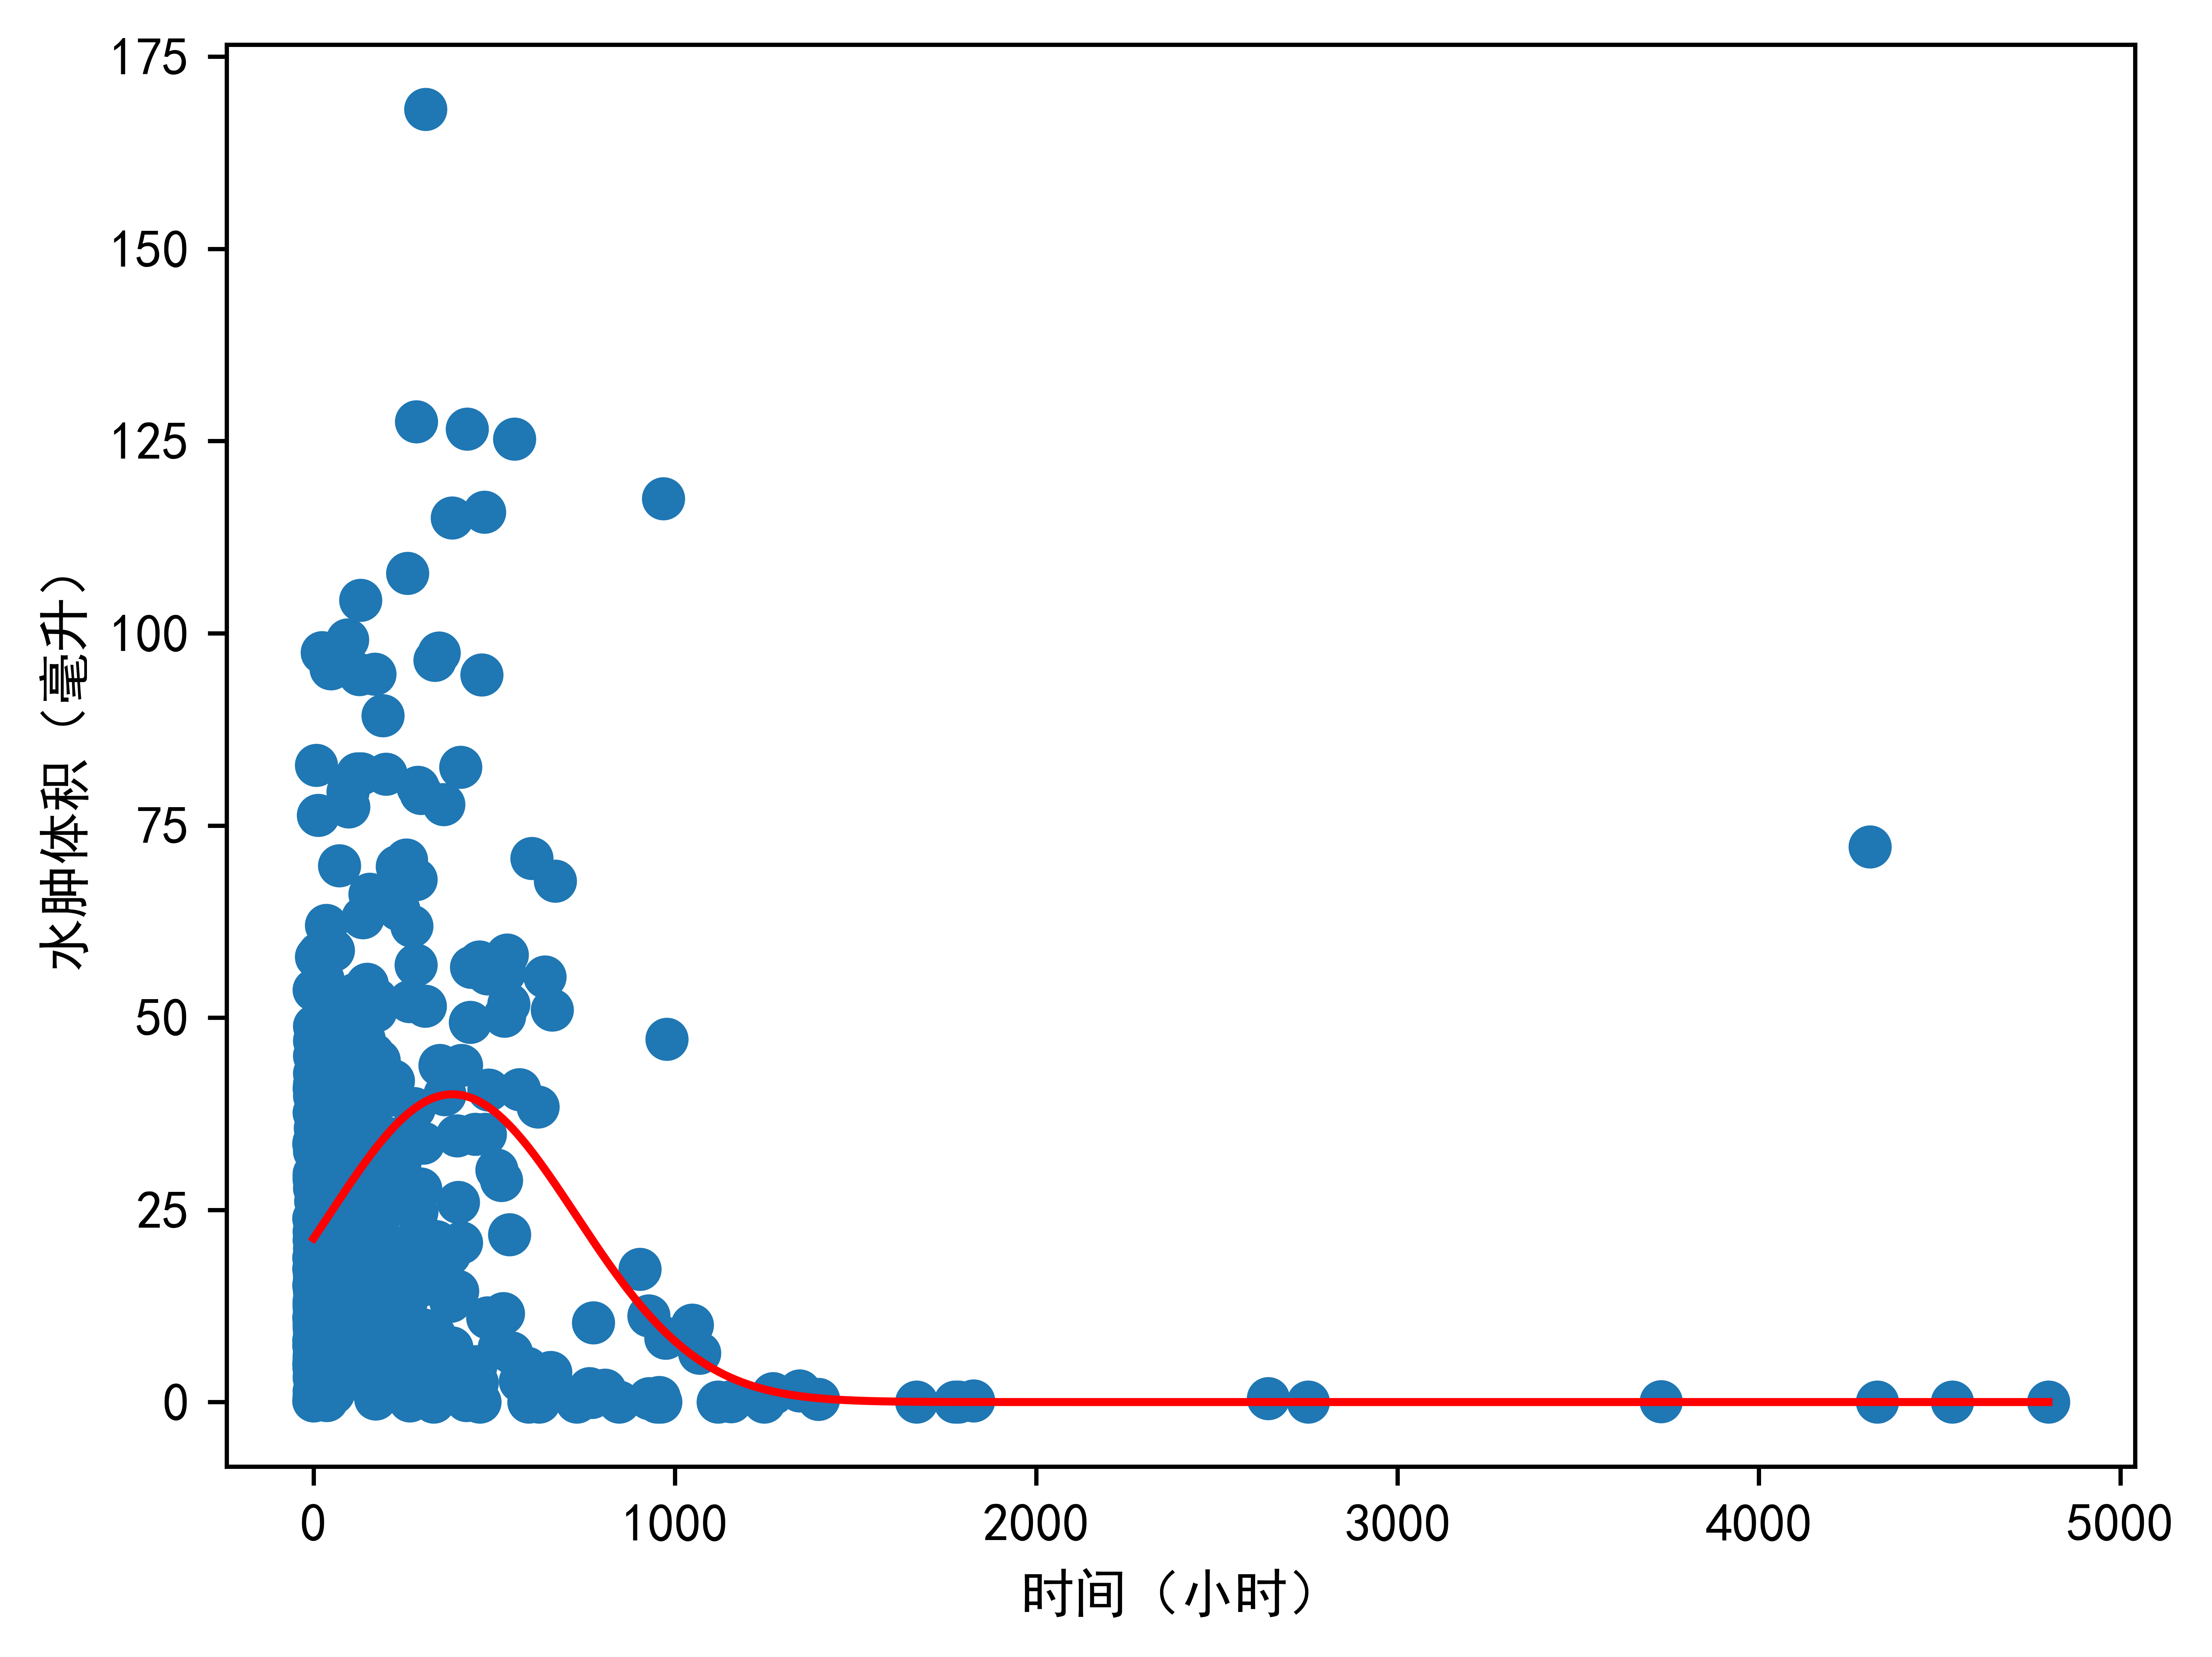

In [28]:
import matplotlib.pyplot as plt
fig = plt.figure(dpi=1000)
x_ = np.linspace(min(x), max(x), 10000)
y_=40.0291422 * np.exp(-(x_ - 384.6771049) ** 2 / (2 * 342.06002898 ** 2))

plt.scatter(x, y,label='原始数据',s=50)
plt.plot(x_,y_,label='拟合曲线',color='r')
plt.xlabel('时间（小时）')
plt.ylabel('水肿体积（毫升）')
fig.savefig('q21拟合结果图.png', dpi=1000, bbox_inches='tight')
plt.show()